# Network Traffic Anomaly Detection Using Recurrent Neural Networks
## Replication File 5 of 6

Benjamin J. Radford, Leonardo M. Apolonio, Antonio J. Trias, and Jim A. Simpson

Paper available: [arXiv:1803.10769v1](https://arxiv.org/pdf/1803.10769.pdf).

DISTRIBUTION STATEMENT A: Approved for public release. 

This research was developed with funding from the Defense Advanced Research Projects Agency (DARPA). The views, opinions and/or findings expressed are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.

In [1]:
import numpy as np
import pandas
import re
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, auc, roc_curve
from keras.layers.core import Masking
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.layers.wrappers import Bidirectional
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.layers import Embedding, TimeDistributed
from tensorflow.python.client import device_lib
from lxml import etree
from itertools import groupby
from gensim.models import Word2Vec
import glob
import math
import itertools
from sklearn.metrics import *
import matplotlib.pyplot as plt

##
## Load data
##
print("Loading data...")
xml_list = glob.glob('data/labeled_flows_xml/*xml')

parser = etree.XMLParser(recover=True)

def xml2df(xml_data):
    root = etree.fromstring(xml_data, parser=parser) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
            all_records.append(record)
    return pandas.DataFrame(all_records)

dfs = []
for ii in xml_list:
    xml_data = open(ii).read()
    dfs.append(xml2df(xml_data))
    
data = pandas.concat(dfs)
data = data.drop_duplicates()
data = data.sort_values("startDateTime")
del dfs

##
## Create IP-dyad hours
##
print("De-dup Flows: "+str(len(data)))
data = data.sort_values('startDateTime')
data['totalBytes'] = data.totalSourceBytes.astype(float) + data.totalDestinationBytes.astype(float)
data['lowIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] <= x[1] else x[1], axis=1)
data['highIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
data['seqId'] = data['lowIP'] + '_' + data['highIP']  + '_' + data['startDateTime'].str[:13]
data['protoBytes'] = data[['protocolName','totalBytes']].apply(lambda x: str(x[0])[0] + str(math.floor(np.log2(x[1] + 1.0))), axis=1)

##
## Group by key and produce sequences
## 
key = data.groupby('seqId')[['Tag','protoBytes']].agg({"Tag":lambda x: "%s" % ','.join([a for a in x]),"protoBytes":lambda x: "%s" % ','.join([str(a) for a in x])})
attacks = [a.split(",") for a in key.Tag.tolist()]
sequences = [a.split(",") for a in key.protoBytes.tolist()]

unique_tokens = list(set([a for b in sequences for a in b]))
le = LabelEncoder()
le.fit(unique_tokens)
sequences = [le.transform(s).tolist() for s in sequences]
sequences = [[b+1 for b in a] for a in sequences]

sequence_attack = zip(attacks, sequences)

##
## Produce sequences for modeling
##
na_value = 0.
seq_len = 10
seq_index = []
seq_x = []
seq_y = []
seq_attack = []
for si, (sa, ss) in enumerate(sequence_attack):
    prepend = [0.] * (seq_len)
    seq =  prepend + ss
    seqa = prepend + sa
    for ii in range(seq_len, len(seq)):
        subseq = seq[(ii-seq_len):(ii)]
        vex = []
        for ee in subseq:
            try:
                vex.append(ee)
            except:
                vex.append(na_value)
        seq_x.append(vex)
        seq_y.append(seq[ii])
        seq_index.append(si)
        seq_attack.append(seqa[ii])
        
##
## Initialize One-hot-encoder
##
ohe = OneHotEncoder(sparse=False)
ohe_y = ohe.fit_transform(np.asarray(seq_y).reshape(-1, 1))
X = np.array(seq_x)

class BatchGenerator(object):
    def __init__(self, batch_size, x, y, ohe):
        self.batch_size = batch_size
        self.n_batches = int(math.floor(np.shape(x)[0] / batch_size))
        self.batch_index = [a * batch_size for a in range(0, self.n_batches)]
        self.x = x
        self.y = y
        self.ohe = ohe
        
    def __iter__(self):
        for bb in itertools.cycle(self.batch_index):
            y = self.y[bb:(bb+self.batch_size)]
            ohe_y = self.ohe.transform(y.reshape(len(y), 1))
            yield (self.x[bb:(bb+self.batch_size),], ohe_y)
            
print("Ready to Go!")

Using TensorFlow backend.


Loading data...
De-dup Flows: 1889172
Ready to Go!


In [2]:
training_boolean = key.index.str.contains("2010-06-12").tolist() + key.index.str.contains("2010-06-11").tolist()
training_sequences = [i for i,v in enumerate(training_boolean) if v]
training_indices = [i for i,v in enumerate(seq_index) if v in training_sequences]

In [3]:
# np.random.seed(123)
print(len(training_indices))
model = Sequential()

# model.add(Masking(0., input_shape=(seq_len,w2v_size)))
model.add(Embedding(output_dim=100, input_dim=len(unique_tokens), mask_zero=True))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, activation="relu", return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50, activation="linear"))
model.add(Dropout(0.2))
model.add(Dense(len(unique_tokens), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# training_data = BatchGenerator(1000, X[np.asarray(train_index)], le_y[np.asarray(train_index)], ohe)

model.fit(X[np.asarray(training_indices)], ohe_y[np.asarray(training_indices)], epochs=5, batch_size=512, verbose=1)

# model.fit_generator(training_data.__iter__(),
#     steps_per_epoch=training_data.n_batches,
#     epochs=30, verbose=1)

132925
Epoch 1/5
132925/132925 [==============================] - 24s - loss: 2.0177 - acc: 0.4069    
Epoch 2/5
132925/132925 [==============================] - 22s - loss: 1.6763 - acc: 0.4629    
Epoch 3/5
132925/132925 [==============================] - 22s - loss: 1.6314 - acc: 0.4718    
Epoch 4/5
132925/132925 [==============================] - 22s - loss: 1.6055 - acc: 0.4787    
Epoch 5/5
132925/132925 [==============================] - 22s - loss: 1.5883 - acc: 0.4833    


In [4]:
model.save("models/protobytes_clean.hd5")
preds = model.predict_proba(X, batch_size=512)
test_index = range(0,len(preds))

1888256/1889171 [============================>.] - ETA: 0s

In [5]:
indexed_preds = zip(np.asarray(seq_index)[np.asarray(test_index)], preds, ohe_y[np.asarray(test_index)], np.asarray(seq_attack)[np.asarray(test_index)])

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='graphics/protobytes_model.pdf', show_shapes=False)

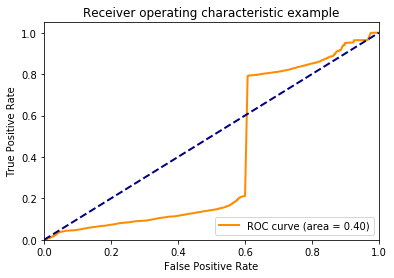

In [7]:
logloss_list = []
for (ii, pp, yy, aa) in indexed_preds:
    ll = -math.log(pp[np.argmax(yy)])
    logloss_list.append(ll)

fpr, tpr, thresholds = roc_curve(np.asarray(seq_attack)[np.asarray(test_index)],logloss_list, pos_label="Attack")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

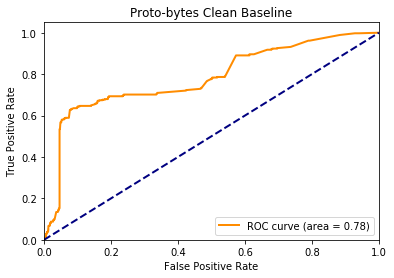

In [9]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.iteritems():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proto-bytes Clean Baseline')
plt.legend(loc="lower right")
plt.savefig("graphics/protobytes_clean.pdf",format="pdf")
plt.show()
